In [31]:
import numpy as np
import astropy.io.fits
import matplotlib.pyplot as plt
import scipy.optimize
%matplotlib inline

# you may have to change the path here in your own copy.
fits = astropy.io.fits.open("../../data/hsc-image-small.fits")
image = fits[0].data
variance = fits[1].data
detections = fits[2].data

psf_moments = {"mx": 0.0, "my": 0.0, "mxx": 3.9771548941134864, "myy": 3.8040164531742597, "mxy": -0.21695453484795038}


def make_coordinate_arrays(shape):
    """
    Returns a meshgrid indexing coordinates given in shape.
    """
    dimensions = np.arange(shape[0]),np.arange(shape[1]) #y,x, 267 tall by 263 wide
    coord_mesh = np.meshgrid(dimensions[1],dimensions[0]) #x,y
    return coord_mesh

def weighted_moments(mesh,image,weight):
    """
    Computes the zeroth, first, and second moments of objects in the image
    given a weight image.
    """
    x,y = mesh[0],mesh[1]
    
    # Zeroth
    m0 = np.sum(image*weight)

    # First
    #x*image*(detections==5).sum()
    mx = 1/m0*np.sum(x*image*weight)
    my = 1/m0*np.sum(y*image*weight)

    # Second
    mxx = 1/m0*np.sum((x-mx)**2*image*weight)
    myy = 1/m0*np.sum((y-my)**2*image*weight)
    mxy = 1/m0*np.sum((x-mx)*(y-my)*image*weight)
    return np.array((m0,mx,my,mxx,myy,mxy))

def convolved_gaussian_image(mesh,moments,psf_moments):
    m0,mx,my,mxx,myy,mxy = moments.tolist()
    mxx += psf_moments['mxx']
    myy += psf_moments['myy']
    mxy += psf_moments['mxy']

    C = [[mxx,mxy],[mxy,myy]]
    Cinv = np.linalg.inv(C)

    x,y = mesh[0],mesh[1]
    matrix_product = (x-mx)**2*Cinv[0,0] + (y-my)**2*Cinv[1,1] + 2*(x-mx)*(y-my)*Cinv[0,1]

    gaussian = np.exp(-1/2*matrix_product)
    #gaussian = np.exp(-1./10000*(mesh[0]**2+mesh[1]**2)) # test gaussian of sigma 100
    gaussian /= gaussian.sum()
    gaussian *= m0
    #pyplot.imshow(gaussian, origin='lower', interpolation='nearest',)
    return gaussian

def residuals(moments,image,variance,psf_moments,mask=None):
    if mask is None:
        mask = np.ones(image.shape)
    mesh = make_coordinate_arrays(image.shape)
    model = convolved_gaussian_image(mesh,moments,psf_moments)
    return (mask*(image-model)/np.sqrt(variance)).flatten()


def foobar(image,variance,mask,psf_moments):
    mesh = make_coordinate_arrays(image.shape)
    guess_moments = weighted_moments(mesh,image,mask)

    guess_moments[3] -= psf_moments['mxx']
    if guess_moments[3] <= 0:
        guess_moments[3] += psf_moments['mxx']

    guess_moments[4] -= psf_moments['myy']
    if guess_moments[4] <= 0:
        guess_moments[4] += psf_moments['myy']

    guess_moments[5] -= psf_moments['mxy']

    bestfit = scipy.optimize.leastsq(residuals,guess_moments,args=(image,variance,psf_moments,mask))
    if bestfit[1] > 4:
        print "fit failed!"
    return bestfit[0]

bestfit = foobar(image,variance,detections==5,psf_moments)

In [7]:
guess_moments

array([ 4098.88037109,   144.74723262,   125.75019614,    54.91206828,
         157.01002277,    53.11421082])

In [12]:
guess_moments

array([ 4098.88037109,   144.74723262,   125.75019614,    50.93491339,
         153.20600631,    53.33116536])

In [33]:
bestfit[0]

3716.2492412014253

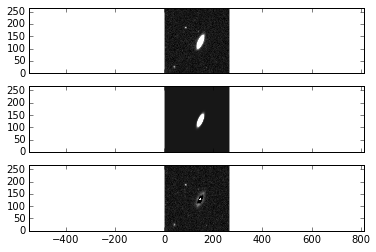

In [53]:
fitted_image = convolved_gaussian_image(make_coordinate_arrays(image.shape),bestfit,psf_moments)

f,axarr = plt.subplots(3,sharex = True,sharey = True)
axarr[0].imshow(image, origin='lower', interpolation='nearest', cmap=pyplot.cm.gray, vmin=-0.1, vmax=1.0)

axarr[1].imshow(fitted_image, origin='lower', interpolation='nearest', cmap=pyplot.cm.gray, vmin=-0.1, vmax=1.0)
axarr[2].imshow(image-fitted_image, origin='lower', interpolation='nearest', cmap=pyplot.cm.gray, vmin=-0.1, vmax=1.0)

In [45]:
plt.subplot(3,1,1,figsize = (2,2))
#plt.figure(figsize = (2,2))
plt.imshow(image, origin='lower', interpolation='nearest', cmap=pyplot.cm.gray, vmin=-0.1, vmax=1.0)
plt.subplot(3,1,2)
fitted_image = convolved_gaussian_image(make_coordinate_arrays(image.shape),bestfit,psf_moments)
plt.imshow(fitted_image, origin='lower', interpolation='nearest',cmap=pyplot.cm.gray, vmin=-0.1, vmax=1.0)
plt.subplot(3,1,3)
plt.imshow(image-fitted_image, origin='lower', interpolation='nearest', cmap=pyplot.cm.gray, vmin=-0.1, vmax=1.0)

plt.show()

AttributeError: Unknown property figsize

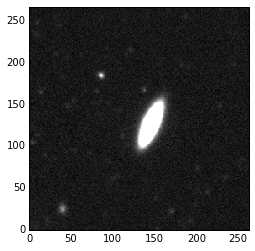

In [44]:
pyplot.imshow(image, origin='lower', interpolation='nearest', cmap=pyplot.cm.gray, vmin=-0.1, vmax=1.0)